Импортируем библиотеки:

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from catboost import CatBoostClassifier

plt.style.use("seaborn-whitegrid")

Загружаем данные:

In [13]:
df_test = pd.read_csv('action_test.csv', index_col=[0])
df_test

,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682
2,ppl_10001,act1_240724,2022-10-14,type 1,type 12,type 1,type 5,type 4,type 6,type 1,type 1,type 13,type 10,NaN
3,ppl_10001,act1_83552,2022-11-27,type 1,type 20,type 10,type 5,type 4,type 6,type 1,type 1,type 5,type 5,NaN
4,ppl_10001,act2_1043301,2022-10-15,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 3015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498682,ppl_99997,act2_4367092,2023-04-22,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1
498683,ppl_99997,act2_4404220,2022-11-12,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1
498684,ppl_99997,act2_448830,2022-08-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1
498685,ppl_99997,act2_450133,2022-08-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1


In [14]:
df_train = pd.read_csv('action_train.csv', index_col=[0], low_memory=False)
df_train

,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,result
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197286,ppl_99994,act2_4668076,2023-06-16,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 418,1
2197287,ppl_99994,act2_4743548,2023-03-30,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1832,1
2197288,ppl_99994,act2_536973,2023-01-19,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,1
2197289,ppl_99994,act2_688656,2023-05-02,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 199,1


Количество уникальных людей в df_train:

In [15]:
df_train['person_id'].nunique()

151295

In [16]:
df_person = pd.read_csv('person.csv', index_col=[0])
df_person

,person_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,...,False,False,True,True,True,True,False,True,True,99
3,ppl_100004,type 2,group 22593,type 3,2022-07-20,type 40,type 25,type 9,type 4,type 16,...,True,True,True,True,True,True,True,True,True,76
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,...,False,False,True,False,False,False,True,True,False,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189113,ppl_99987,type 1,group 8600,type 1,2022-04-02,type 4,type 6,type 4,type 3,type 11,...,False,False,False,True,False,True,False,True,True,89
189114,ppl_9999,type 2,group 17304,type 2,2023-02-23,type 6,type 2,type 8,type 3,type 11,...,False,False,False,False,False,False,False,False,False,0
189115,ppl_99992,type 2,group 17304,type 2,2020-06-25,type 5,type 5,type 3,type 4,type 16,...,False,False,False,False,False,False,False,False,False,0
189116,ppl_99994,type 2,group 17764,type 3,2023-01-06,type 2,type 7,type 2,type 1,type 2,...,True,True,True,True,False,True,True,True,True,95


In [17]:
df_person.iloc[:1, :20]

,person_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,char_11,char_12,char_13,char_14,char_15,char_16,char_17
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,type 2,True,False,False,True,True,False,True,False


In [18]:
df_person.iloc[:1, 20:]

,char_18,char_19,char_20,char_21,char_22,char_23,char_24,char_25,char_26,char_27,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,False,False,False,True,False,False,False,False,False,True,...,False,True,True,False,False,True,True,True,False,36


In [19]:
df_person['char_1'].value_counts()

type 2    173867
type 1     15251
Name: char_1, dtype: int64

Получим общую информацию о данных:

In [20]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498687 entries, 0 to 498686
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   person_id    498687 non-null  object
 1   action_id    498687 non-null  object
 2   date         498687 non-null  object
 3   action_type  498687 non-null  object
 4   char_1       40092 non-null   object
 5   char_2       40092 non-null   object
 6   char_3       40092 non-null   object
 7   char_4       40092 non-null   object
 8   char_5       40092 non-null   object
 9   char_6       40092 non-null   object
 10  char_7       40092 non-null   object
 11  char_8       40092 non-null   object
 12  char_9       40092 non-null   object
 13  char_10      458595 non-null  object
dtypes: object(14)
memory usage: 57.1+ MB


In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2197291 entries, 0 to 2197290
Data columns (total 15 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   person_id    object
 1   action_id    object
 2   date         object
 3   action_type  object
 4   char_1       object
 5   char_2       object
 6   char_3       object
 7   char_4       object
 8   char_5       object
 9   char_6       object
 10  char_7       object
 11  char_8       object
 12  char_9       object
 13  char_10      object
 14  result       int64 
dtypes: int64(1), object(14)
memory usage: 268.2+ MB


In [22]:
df_train.isnull().sum()

person_id            0
action_id            0
date                 0
action_type          0
char_1         2039676
char_2         2039676
char_3         2039676
char_4         2039676
char_5         2039676
char_6         2039676
char_7         2039676
char_8         2039676
char_9         2039676
char_10         157615
result               0
dtype: int64

In [23]:
df_person.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189118 entries, 0 to 189117
Data columns (total 41 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   person_id  189118 non-null  object
 1   char_1     189118 non-null  object
 2   group_1    189118 non-null  object
 3   char_2     189118 non-null  object
 4   date       189118 non-null  object
 5   char_3     189118 non-null  object
 6   char_4     189118 non-null  object
 7   char_5     189118 non-null  object
 8   char_6     189118 non-null  object
 9   char_7     189118 non-null  object
 10  char_8     189118 non-null  object
 11  char_9     189118 non-null  object
 12  char_10    189118 non-null  bool  
 13  char_11    189118 non-null  bool  
 14  char_12    189118 non-null  bool  
 15  char_13    189118 non-null  bool  
 16  char_14    189118 non-null  bool  
 17  char_15    189118 non-null  bool  
 18  char_16    189118 non-null  bool  
 19  char_17    189118 non-null  bool  
 20  char

Соединим train и test:

In [24]:
df = pd.concat([df_train, df_test])
df

,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,result
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0.0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0.0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0.0
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0.0
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498682,ppl_99997,act2_4367092,2023-04-22,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,NaN
498683,ppl_99997,act2_4404220,2022-11-12,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,NaN
498684,ppl_99997,act2_448830,2022-08-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,NaN
498685,ppl_99997,act2_450133,2022-08-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,NaN


Информация об уникальных значениях:

In [25]:
for i in df.columns:
    print(df[i].value_counts())

ppl_294918    55103
ppl_370270    53668
ppl_105739    45936
ppl_54699     23969
ppl_64887      7052
              ...  
ppl_148331        1
ppl_240658        1
ppl_68222         1
ppl_68224         1
ppl_144036        1
Name: person_id, Length: 189118, dtype: int64
act2_1734928    1
act2_1161082    1
act2_1182655    1
act2_1191597    1
act2_1206241    1
               ..
act2_13152      1
act2_1464395    1
act2_1620610    1
act2_1823732    1
act2_847967     1
Name: action_id, Length: 2695978, dtype: int64
2022-09-16    53624
2022-09-30    51679
2022-10-23    45361
2022-09-15    37307
2022-10-15    35497
              ...  
2023-08-19       71
2022-12-05       55
2022-12-12       41
2023-08-21       21
2023-08-20       10
Name: date, Length: 411, dtype: int64
type 2    1127847
type 5     614173
type 3     489339
type 4     257680
type 1     197707
type 6       5304
type 7       3928
Name: action_type, dtype: int64
type 2     47892
type 5     43166
type 12    18902
type 1     18824
type 

In [26]:
for i in df.columns:
    print(df[i].unique())

['ppl_100' 'ppl_100002' 'ppl_100003' ... 'ppl_99975' 'ppl_99986'
 'ppl_99997']
['act2_1734928' 'act2_2434093' 'act2_3404049' ... 'act2_448830'
 'act2_450133' 'act2_847967']
['2023-08-26' '2022-09-27' '2023-08-04' '2022-11-23' '2023-02-07'
 '2023-06-28' '2022-08-10' '2023-03-02' '2022-09-13' '2023-02-10'
 '2022-08-23' '2022-08-16' '2023-02-02' '2022-08-30' '2023-02-21'
 '2023-02-15' '2023-05-03' '2023-08-02' '2023-08-30' '2022-08-25'
 '2022-09-06' '2022-08-26' '2023-07-27' '2022-10-05' '2022-07-27'
 '2023-01-26' '2023-01-25' '2023-03-26' '2022-11-25' '2022-09-16'
 '2023-01-12' '2023-01-11' '2022-11-26' '2022-09-15' '2022-08-27'
 '2022-09-21' '2022-09-29' '2023-01-10' '2022-09-23' '2022-11-27'
 '2023-04-26' '2023-07-15' '2023-02-24' '2023-06-09' '2022-07-26'
 '2023-06-15' '2023-02-28' '2022-08-18' '2023-07-28' '2023-02-03'
 '2022-11-15' '2022-11-12' '2023-02-04' '2022-11-11' '2023-08-25'
 '2022-10-20' '2022-11-13' '2022-11-01' '2022-09-25' '2022-12-31'
 '2023-07-12' '2022-10-13' '2023-07

Дополним наш dataframe данными об уникальных людях:

In [27]:
df = df.merge(df_person, left_on='person_id', right_on='person_id')

In [28]:
df = df.set_index('action_id')

In [29]:
df

,person_id,date_x,action_type,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
action_id,,,,,,,,,,,,,,,,,,,,,
act2_1734928,ppl_100,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
act2_2434093,ppl_100,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
act2_3404049,ppl_100,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
act2_3651215,ppl_100,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
act2_4109017,ppl_100,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,True,True,False,False,True,True,True,False,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
act2_4367092,ppl_99997,2023-04-22,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,36
act2_4404220,ppl_99997,2022-11-12,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,36
act2_448830,ppl_99997,2022-08-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,False,False,False,36


# Предобработка

Данные содержат множество категориальных переменных, сами значения нам не важны в условиях отстуствия расшифровки знвчений данных, поэтому нам достаточно просто перекодировать их в дискретный набор чисел, чтобы дерево решений легко разбивало всё на листья.

In [30]:
X = df.copy()
y = X.pop('result')

# Закодируем категориальные переменные
for column in X.select_dtypes('object'):
    X[column], _ = X[column].factorize()

discrete_features = X.dtypes == int

In [31]:
X

,person_id,date_x,action_type,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
action_id,,,,,,,,,,,,,,,,,,,,,
act2_1734928,0,0,0,-1,-1,-1,-1,-1,-1,-1,...,False,True,True,False,False,True,True,True,False,36
act2_2434093,0,1,1,-1,-1,-1,-1,-1,-1,-1,...,False,True,True,False,False,True,True,True,False,36
act2_3404049,0,1,1,-1,-1,-1,-1,-1,-1,-1,...,False,True,True,False,False,True,True,True,False,36
act2_3651215,0,2,1,-1,-1,-1,-1,-1,-1,-1,...,False,True,True,False,False,True,True,True,False,36
act2_4109017,0,0,1,-1,-1,-1,-1,-1,-1,-1,...,False,True,True,False,False,True,True,True,False,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
act2_4367092,189117,233,1,-1,-1,-1,-1,-1,-1,-1,...,False,False,False,False,False,False,False,False,False,36
act2_4404220,189117,51,1,-1,-1,-1,-1,-1,-1,-1,...,False,False,False,False,False,False,False,False,False,36
act2_448830,189117,291,1,-1,-1,-1,-1,-1,-1,-1,...,False,False,False,False,False,False,False,False,False,36


In [32]:
y

action_id
act2_1734928    0.0
act2_2434093    0.0
act2_3404049    0.0
act2_3651215    0.0
act2_4109017    0.0
               ... 
act2_4367092    NaN
act2_4404220    NaN
act2_448830     NaN
act2_450133     NaN
act2_847967     NaN
Name: result, Length: 2695978, dtype: float64

Разобьём выборку на train, valid, test:

In [33]:
X_tr_val, X_test, y_tr_val, y_test = train_test_split(X, y, train_size=len(df_train), shuffle=False)

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X_tr_val, y_tr_val, test_size=.2)

После label-энкодинга мы можем посмотреть mutual information, она может улавливать не только линейную зависимость, поэтому лучше чем корреляция.

In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train, y_train, discrete_features)

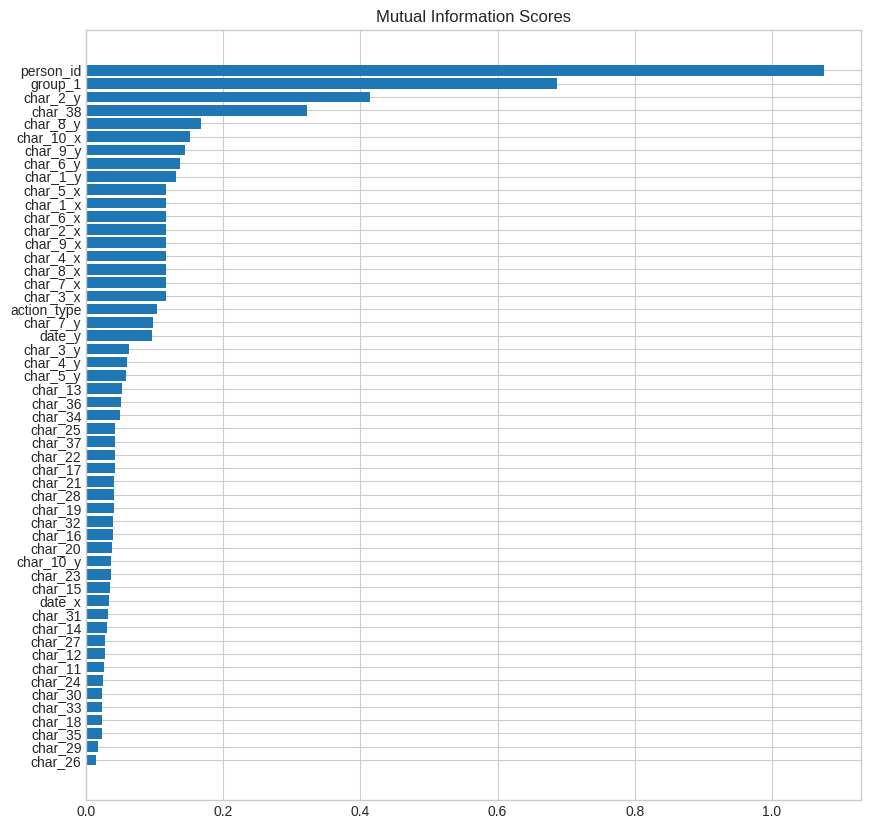

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(10, 10))
plot_mi_scores(mi_scores)

Рассмотрим некоторые из характеристик, наиболее вляиющих на target:

<AxesSubplot:xlabel='char_2_y', ylabel='result'>

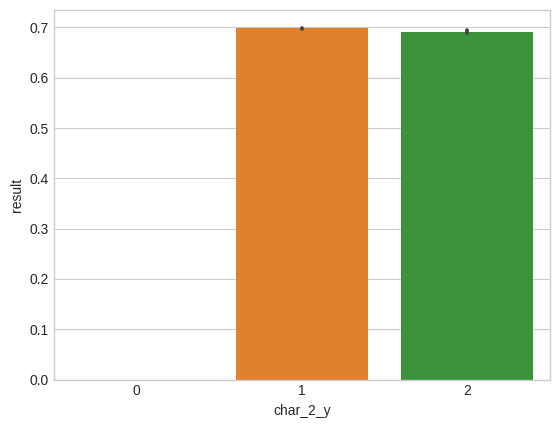

In [36]:
sns.barplot(x=X_train['char_2_y'], y=y_train)

<AxesSubplot:xlabel='char_8_y', ylabel='result'>

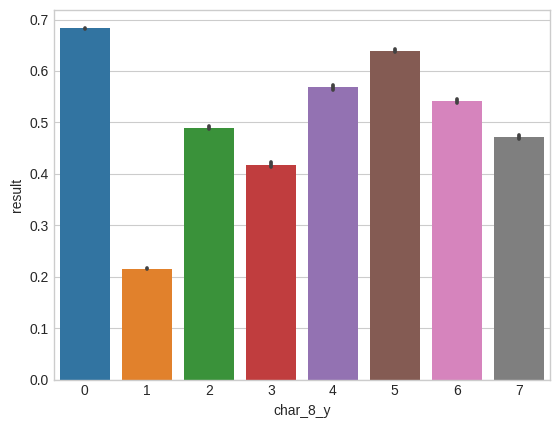

In [37]:
sns.barplot(x=X_train['char_8_y'], y=y_train)

<AxesSubplot:xlabel='char_38', ylabel='result'>

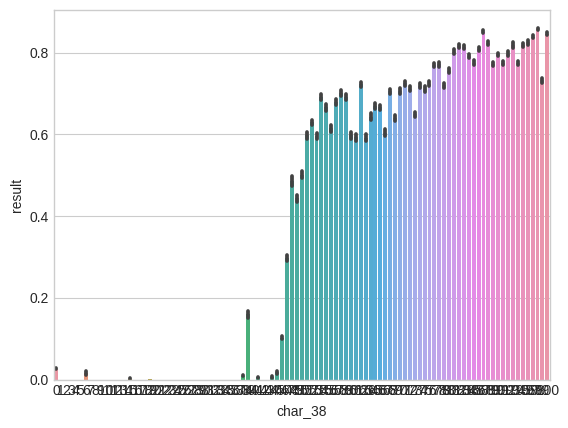

In [29]:
sns.barplot(x=X_train['char_38'], y=y_train)

Как видно, различия по категориям весьма заметны.

# Модель

Создадим лист категориальных фичей:

In [30]:
cat_feat = list(X.columns)[:-1]

Используем модель catboost для классификации:

In [31]:
model = CatBoostClassifier(learning_rate=0.25, iterations=50)

Загружаем данные в модель, отмечаем наличие категориальных переменных:

In [32]:
model.fit(X_train, y_train, cat_features=cat_feat)

0:	learn: 0.2986313	total: 754ms	remaining: 36.9s
1:	learn: 0.1541627	total: 1.5s	remaining: 36.1s
2:	learn: 0.1166045	total: 2.05s	remaining: 32.1s
3:	learn: 0.0997701	total: 2.53s	remaining: 29.1s
4:	learn: 0.0903211	total: 3.11s	remaining: 28s
5:	learn: 0.0846188	total: 3.68s	remaining: 27s
6:	learn: 0.0823329	total: 4.13s	remaining: 25.4s
7:	learn: 0.0804627	total: 4.55s	remaining: 23.9s
8:	learn: 0.0790198	total: 5s	remaining: 22.8s
9:	learn: 0.0779725	total: 5.48s	remaining: 21.9s
10:	learn: 0.0771035	total: 5.94s	remaining: 21.1s
11:	learn: 0.0765141	total: 6.4s	remaining: 20.3s
12:	learn: 0.0759459	total: 6.88s	remaining: 19.6s
13:	learn: 0.0756628	total: 7.4s	remaining: 19s
14:	learn: 0.0754992	total: 7.92s	remaining: 18.5s
15:	learn: 0.0752386	total: 8.42s	remaining: 17.9s
16:	learn: 0.0750962	total: 8.97s	remaining: 17.4s
17:	learn: 0.0747531	total: 9.46s	remaining: 16.8s
18:	learn: 0.0746227	total: 9.96s	remaining: 16.2s
19:	learn: 0.0745208	total: 10.5s	remaining: 15.7s
20

Посчитаем метрику roc-auc для нашей модели на train-выборке:

In [36]:
probs = model.predict_proba(X_train)
probs = probs[:, 1]

In [37]:
roc_auc_score(y_train, probs)

0.9984095747941844

Построим саму кривую:

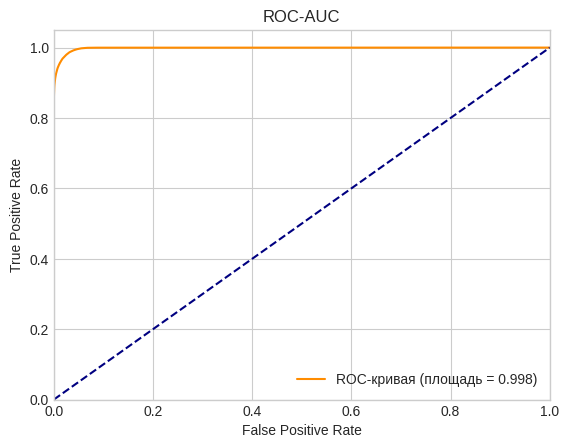

In [38]:
fpr, tpr, treshold = roc_curve(y_train, probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         label='ROC-кривая (площадь = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC')
plt.legend(loc="lower right")
plt.show()

# Валидация

Посчитаем метрику на валидационной выборке:

In [39]:
probs_val = model.predict_proba(X_valid)
probs_val = probs_val[:, 1]

In [40]:
roc_auc_score(y_valid, probs_val)

0.9978988266035417

Как видно, модель показала достаточно высокий результат.

# Результат

Сделаем предсказание и запишем в csv-файл:

In [41]:
result = model.predict(X_test)

In [74]:
act_id = df_test['action_id']

In [80]:
prediction = pd.DataFrame(columns=['result'], index=act_id)

In [82]:
prediction['result'] = result

In [87]:
prediction.to_csv('prediction.csv')

In [89]:
pd.read_csv('prediction.csv', index_col=[0])

,result
action_id,
act1_249281,0.0
act2_230855,0.0
act1_240724,1.0
act1_83552,1.0
act2_1043301,1.0
...,...
act2_4367092,0.0
act2_4404220,0.0
act2_448830,0.0
